In [1]:
### Get different version of sklearn
# !pip uninstall scikit-learn
# !pip install scikit-learn==1.0.0
# import sklearn
# print(sklearn.__version__)

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/scikit_learn-1.2.2.dist-info/*
    /usr/local/lib/python3.9/dist-packages/scikit_learn.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.9/dist-packages/sklearn/*
Proceed (Y/n)? y
Y
  Successfully uninstalled scikit-learn-1.2.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 15.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.10.1 requires scikit-learn>=1.0.2, but you have scikit-learn 1.0 which is incompatible.
1.0


In [2]:
"""Volume 2: Non-negative Matrix Factorization.
Nathan Schill
Section 2
Thurs. Mar. 30, 2023
"""

import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import os
from imageio import imread
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error as mse

import itertools

In [3]:
#Problems 1-2
class NMFRecommender:

    def __init__(self, random_state=15, rank=3, max_iter=200, tol=1e-3):
        """The parameter values for the algorithm"""

        # Store attributes
        self.random_state = random_state
        self.rank = rank
        self.max_iter = max_iter
        self.tol = tol
        
    
    def initialize_matrices(self, m, n):
        """Randomly initialize the W and H matrices,"""

        # Init random seed
        np.random.seed(self.random_state)

        # Init W and H
        self.W = np.random.rand(m, self.rank)
        self.H = np.random.rand(self.rank, n)

        return self.W, self.H

      
    def fit(self, V):
        """Fits W and H weight matrices using CVXPY"""

        # Init W, H in correct shape with random values
        W = cp.Variable(self.W.shape, nonneg=True)
        W.value = self.W

        H = cp.Variable(self.H.shape, nonneg=True)
        H.value = self.H

        # Minimze Frobenius norm distance |V - WH|
        W0, H0 = self.W, self.H
        for _ in range(self.max_iter):
            # Fix H and solve for W
            H0 = H.value
            objW = cp.Minimize(cp.norm(V - W@H0, 'fro'))
            cp.Problem(objW).solve()

            # Fix W and solve for H
            W0 = W.value
            objH = cp.Minimize(cp.norm(V - W0@H, 'fro'))
            cp.Problem(objH).solve()
            
            # Difference between previous and current W and H is less than tol
            if np.linalg.norm(self.W - W0, ord='fro') < self.tol and \
               np.linalg.norm(self.H - H0, ord='fro') < self.tol:
               
               # Save and break
               self.W, self.H = W0, H0
               break
            
            # Store current iteration's values
            self.W, self.H = W0, H0


    def reconstruct(self):
        """Reconstruct V matrix for comparison against the original V"""

        return self.W @ self.H

# Init
m, n = 5, 4
V = np.random.rand(m, n)

# Fit
nmf = NMFRecommender()
nmf.initialize_matrices(*V.shape)
nmf.fit(V)

# Reconstruct and compare
reconstruction = nmf.reconstruct()
print(reconstruction)
print(V)
print(np.linalg.norm(V - reconstruction, ord='fro'))

[[0.19387414 0.22320806 0.05304868 0.46175185]
 [0.4898682  0.6968775  0.60564289 0.64416663]
 [0.53930424 0.74782323 0.15098188 0.86783936]
 [0.59233364 0.82940686 0.65638784 0.83629693]
 [0.14273821 0.07027218 0.38405888 0.58462428]]
[[0.15224582 0.24519446 0.05401605 0.46849091]
 [0.43360382 0.72659414 0.60731529 0.65323314]
 [0.5516211  0.74131781 0.1506156  0.8658546 ]
 [0.63884032 0.80484371 0.65500545 0.82880275]
 [0.15280627 0.06467575 0.38382138 0.58299477]]
0.09774568225253441


In [4]:
def prob3():
    """Run NMF recommender on the grocery store example"""
    V = np.array(
        [
            [0, 1, 0, 1, 2, 2],
            [2, 3, 1, 1 ,2, 2],
            [1, 1, 1, 0, 1, 1],
            [0, 2, 3, 4, 1, 1],
            [0, 0, 0, 0, 1, 0]
        ]
    )

    # Init and fit
    nmf = NMFRecommender(rank=2)
    nmf.initialize_matrices(*V.shape)
    nmf.fit(V)

    # Take argmax along columns. The argmax on each column will be 1
    # if that person's component 2 is greater than their component 1.
    # Sum up the 1s.
    return nmf.W, nmf.H, np.sum(np.argmax(nmf.H, axis=0))

prob3()

(array([[4.32357340e-01, 1.55958368e+00],
        [7.28830824e-01, 2.67353753e+00],
        [2.59497870e-01, 1.23222299e+00],
        [2.77133682e+00, 7.42173394e-08],
        [2.00262945e-09, 3.68909407e-01]]),
 array([[9.14789740e-08, 7.26347516e-01, 1.07598515e+00, 1.44658120e+00,
         3.52992321e-01, 3.65556964e-01],
        [5.85644297e-01, 7.72134844e-01, 6.57075361e-02, 8.93992985e-09,
         8.03673962e-01, 7.67537884e-01]]),
 4)

In [6]:
### Unzip if needed (Google Colab)
# if not os.path.exists('faces94'):
#     !unzip -q faces94.zip

In [7]:
# Get data
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory.
    Flatten and convert each image to grayscale.

    Parameters:
        path (str): The directory containing the dataset of images.

    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def show(image, m=200, n=180, plt_show=False):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.

    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
        plt_show (bool): if True, call plt.show() at the end
    """
    # Scale image
    image = image / 255
    # Reshape image
    image = np.reshape(image,(m,n))
    # Show image
    plt.imshow(image,cmap = "gray")
    
    if plt_show:
        plt.show()

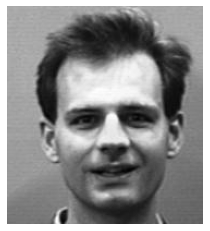

In [55]:
# Plot original third face
IDX = 2
V = get_faces()
show(V[:, IDX])
plt.axis('off')
plt.show()

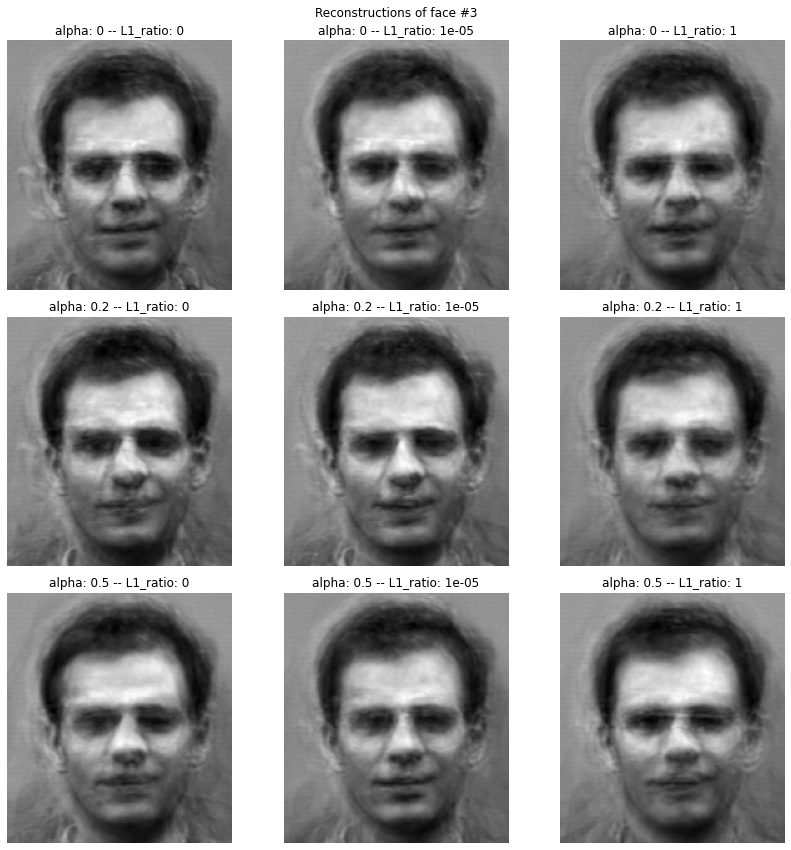

In [35]:
def prob4():
    """
        Gridsearch over rank, alpha and l1_ratio values to reconstruct 
        image using NMF. Plot all reconstructed images.
    """

    # Index of third face
    IDX = 2

    # Hyperparameters
    N_COMPONENTS = 75
    MAX_ITER = 200
    ALPHA = [0, 0.2, 0.5]
    L1_RATIO = [0, 1e-5, 1]
    
    # Get faces
    V = get_faces()

    # The Cartesian product of alphas and l1_ratios
    hyperparam_pairs = list(itertools.product(ALPHA, L1_RATIO))
    
    # Get subplots
    FIG_SIZE = (12, 12)
    fig, axs = plt.subplots(len(ALPHA), len(L1_RATIO), figsize=FIG_SIZE)
    axs = axs.flatten()

    # Store norm differences between original face and reconstructions
    face_norm_diffs = [None] * len(axs)

    for i, (ax, (alpha, l1_ratio)) in enumerate(zip(axs, hyperparam_pairs)):
        # Fit model
        model = NMF(n_components=N_COMPONENTS, max_iter=MAX_ITER,
                    alpha=alpha, l1_ratio=l1_ratio)
        W = model.fit_transform(V)
        H = model.components_

        # Reconstruct one face; store norm difference from original
        reconstruction = W@H[:, IDX]
        face_norm_diffs[i] = np.linalg.norm(V[:, IDX] - reconstruction)

        # Show reconstruction
        plt.sca(ax)
        show(reconstruction)
        ax.set_title(f'alpha: {alpha} -- L1_ratio: {l1_ratio}')
        ax.set_axis_off()
    
    # Plot properties
    plt.suptitle(f'Reconstructions of face #{IDX+1}')
    plt.tight_layout()
    plt.show()

    return face_norm_diffs, hyperparam_pairs
    
face_norm_diffs, hyperparam_pairs = prob4()

In [40]:
# Best hyperparameters
alpha, l1_ratio = hyperparam_pairs[np.argmin(face_norm_diffs)]
alpha, l1_ratio

(0.2, 1e-05)

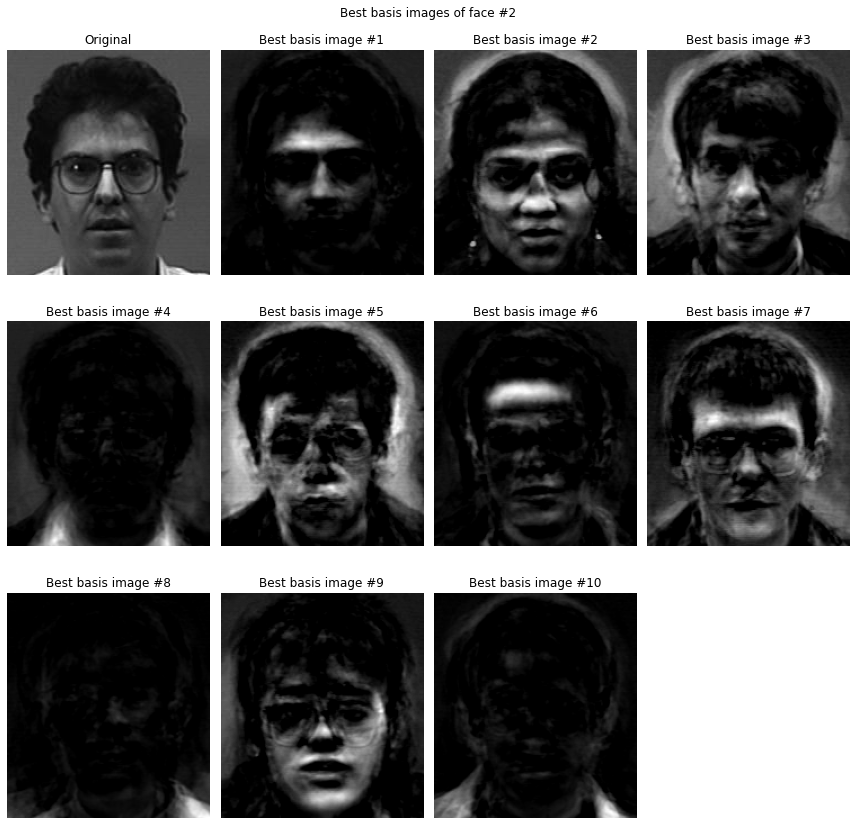

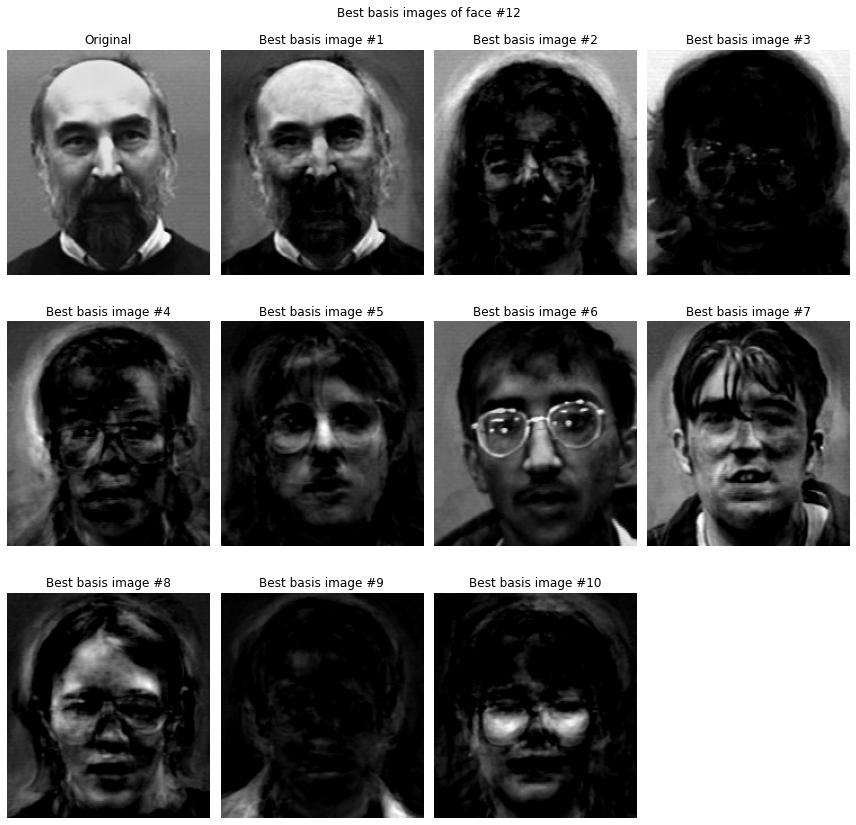

In [56]:
def prob5():
    '''
        Find the 10 basis faces with the largest coefficients 
        corresponding to the the second and twelfth face in the dataset. 
        Plot these basis faces along with the original image using 
        subplots
    '''

    # Indices of 2nd and 12th faces
    IDXS = (1, 11)

    # For each face, get top 10 basis images
    NUM_BASIS_IMAGES = 10

    FIG_SIZE = (12, 12)

    # Hyperparameters
    N_COMPONENTS = 75
    MAX_ITER = 200
    
    # Best hyperparameters obtained from previous problem
    ALPHA, L1_RATIO = 0.2, 1e-05
    
    # Get faces
    V = get_faces()

    # Fit model
    model = NMF(n_components=N_COMPONENTS, max_iter=MAX_ITER,
                alpha=alpha, l1_ratio=l1_ratio)
    W = model.fit_transform(V)
    H = model.components_

    for i in IDXS:
        # Get subplots (need 11)
        fig, axs = plt.subplots(3, 4, figsize=FIG_SIZE)
        axs = axs.flatten()
        plt.delaxes(axs[-1])

        # Get best basis images (largest coefficients at end, so then reverse)
        best_basis_idxs = np.argsort(H[:, i])[-NUM_BASIS_IMAGES:][::-1]

        # Show original image
        ax = axs[0]
        plt.sca(ax)
        show(V[:,i])
        ax.set_title('Original')
        ax.set_axis_off()

        for j, (ax, best_basis_i) in enumerate(zip(axs[1:], best_basis_idxs)):
            # Show basis image
            plt.sca(ax)
            show(W[:, best_basis_i])
            ax.set_title(f'Best basis image #{j+1}')
            ax.set_axis_off()
    
        # Plot properties
        plt.suptitle(f'Best basis images of face #{i+1}')
        plt.tight_layout()
        plt.show()

prob5()

The basis faces highlight different features: backgrounds/silhouettes, foreheads, cheeks, glasses, clothes/collars.

The first face has darker basis faces than the second face, and all its basis faces have dark hair/foreheads while the second's don't.